In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

In [2]:
import sys
if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")
from pbcpy.base import DirectCell, ReciprocalCell, Coord
from pbcpy.grid import DirectGrid, ReciprocalGrid
from pbcpy.field import DirectField, ReciprocalField
from pbcpy.functionals import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
#

In [3]:
from pbcpy.local_functionals_utils import ThomasFermiEnergy, ThomasFermiPotential
from pbcpy.local_functionals_utils import vonWeizsackerEnergy, vonWeizsackerPotential

In [4]:
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF

In [5]:
mol = PP(filepp='Al_fde_rho.pp').read()

In [6]:
dens_real_space = mol.field

# Local and Semilocal Functionals energy and potential

In [7]:
ThomasFermi = Functional(name='TF',energydensity=ThomasFermiEnergy(dens_real_space),
                         potential=ThomasFermiPotential(dens_real_space))

In [8]:
vonWeizsacker = Functional(name='vW',energydensity=vonWeizsackerEnergy(dens_real_space),
                           potential=vonWeizsackerPotential(dens_real_space,Sigma=0.26))

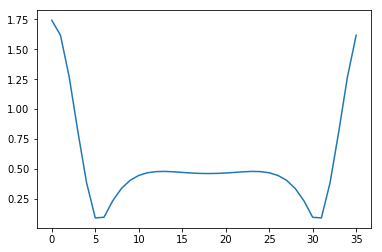

In [9]:
plt.plot(ThomasFermi.potential[:,0,0])
plt.show()

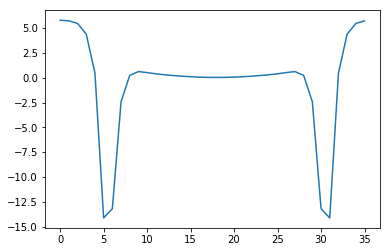

In [10]:
plt.plot(vonWeizsacker.potential[:,0,0])
plt.show()

In [39]:
TFpvW=ThomasFermi.sum(vonWeizsacker)
type(TFpvW)

pbcpy.functionals.Functional

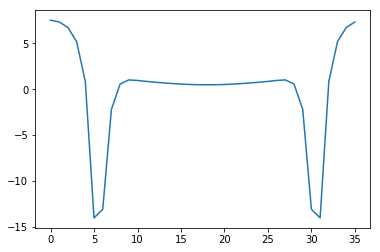

In [12]:
plt.plot(TFpvW.potential[:,0,0])
plt.show()

# $E_{Nel}$ energy and potential

In [13]:
natoms=np.shape(mol.ions)[0]

In [14]:
NuclearElectron = mol.ions[0].local_PP(grid=dens_real_space.grid,rho=dens_real_space,outfile='./Al_lda.oe01.recpot')
for i in range(1,natoms,1):
    eN_tmp = mol.ions[i].local_PP(grid=dens_real_space.grid,rho=dens_real_space,outfile='./Al_lda.oe01.recpot')
    NuclearElectron = NuclearElectron.sum(eN_tmp)

Recpot pseudopotential ./Al_lda.oe01.recpot loaded
Recpot pseudopotential ./Al_lda.oe01.recpot loaded


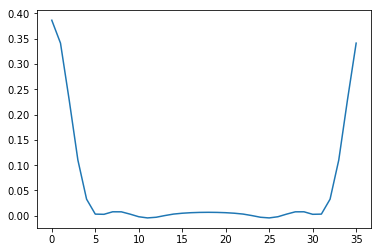

In [15]:
plt.plot(NuclearElectron.energydensity[:,0,0])
plt.show()

In [16]:
NuclearElectron.energydensity.integral()

1.2869681949752771

In [17]:
ThomasFermi.energydensity.integral()

1.6174727743659869

In [18]:
vonWeizsacker.energydensity.integral()

1.4993606133322184

In [19]:
TFpvW.energydensity.integral()

3.1168333876982044

In [20]:
import pylibxc

In [21]:
from pylibxc.functional import LibXCFunctional
from pbcpy.semilocal_xc import *

In [22]:
func = LibXCFunctional('gga_k_tfvw', "unpolarized")

In [23]:
pylibxc.util.xc_available_functional_names()

['lda_x',
 'lda_c_wigner',
 'lda_c_rpa',
 'lda_c_hl',
 'lda_c_gl',
 'lda_c_xalpha',
 'lda_c_vwn',
 'lda_c_vwn_rpa',
 'lda_c_pz',
 'lda_c_pz_mod',
 'lda_c_ob_pz',
 'lda_c_pw',
 'lda_c_pw_mod',
 'lda_c_ob_pw',
 'lda_c_2d_amgb',
 'lda_c_2d_prm',
 'lda_c_vbh',
 'lda_c_1d_csc',
 'lda_x_2d',
 'lda_xc_teter93',
 'lda_x_1d',
 'lda_c_ml1',
 'lda_c_ml2',
 'lda_c_gombas',
 'lda_c_pw_rpa',
 'lda_c_1d_loos',
 'lda_c_rc04',
 'lda_c_vwn_1',
 'lda_c_vwn_2',
 'lda_c_vwn_3',
 'lda_c_vwn_4',
 'lda_xc_zlp',
 'lda_k_tf',
 'lda_k_lp',
 'lda_xc_ksdt',
 'lda_c_chachiyo',
 'lda_c_lp96',
 'lda_x_rel',
 'lda_xc_1d_ehwlrg_1',
 'lda_xc_1d_ehwlrg_2',
 'lda_xc_1d_ehwlrg_3',
 'lda_x_erf',
 'lda_xc_lp_a',
 'lda_xc_lp_b',
 'lda_x_rae',
 'lda_k_zlp',
 'lda_c_mcweeny',
 'lda_c_br78',
 'lda_c_pk09',
 'lda_c_ow_lyp',
 'lda_c_ow',
 'lda_xc_gdsmfb',
 'lda_c_gk72',
 'lda_c_karasiev',
 'lda_k_lp96',
 'gga_x_gam',
 'gga_c_gam',
 'gga_x_hcth_a',
 'gga_x_ev93',
 'gga_x_bcgp',
 'gga_c_bcgp',
 'gga_x_lambda_oc2_n',
 'gga_x_b86_r',


In [24]:
print(func)

<pylibxc.functional.LibXCFunctional (gga_k_tfvw) object at 0x10bd59a58>


In [25]:
func.describe()

'Functional ID: 52\nFunctional Name: gga_k_tfvw\nAttributes:\n    Name: Thomas-Fermi plus von Weiszaecker correction\n    Kind: 3\n  Family: 2\nCitations:\n   C. F. von Weizsäcker, Z. Phys. 96, 431 (1935)'

In [26]:
inp = {
    "rho": dens_real_space[:,:,:].reshape(np.shape(dens_real_space)[0]*np.shape(dens_real_space)[1]*np.shape(dens_real_space)[2]),
    "sigma": dens_real_space[:,:,:].sigma()[:,:,:].reshape(np.shape(dens_real_space)[0]*np.shape(dens_real_space)[1]*np.shape(dens_real_space)[2])
}

In [27]:
out2=Compute_LibXC(inp,"gga_k_tfvw",1)

Computing gga_k_tfvw by LibXC


In [28]:
inp2=Get_LibXC_Input(dens_real_space)

In [29]:
inp2["sigma"]-inp["sigma"]

DirectField([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [30]:
out = func.compute(inp,do_exc=True)

In [31]:
print(out["vrho"]-out2["vrho"])

[[ 0.  0.  0. ...,  0.  0.  0.]]


In [32]:
vsigma=out["vsigma"].reshape(np.shape(dens_real_space)[0],np.shape(dens_real_space)[1],np.shape(dens_real_space)[2])

In [33]:
vsigma=DirectField(dens_real_space.grid,griddata_3d=vsigma)

In [34]:
type(vsigma)

pbcpy.field.DirectField

In [35]:
TFpvW_LibXC = Get_LibXC_Output(out,dens_real_space)

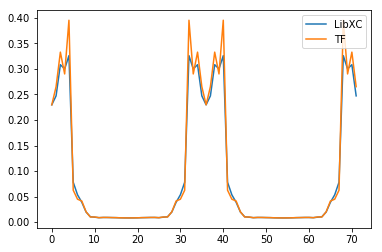

In [36]:
plt.plot(TFpvW_LibXC.energydensity[0,0,:,0],label=TFpvW_LibXC.name)
plt.plot(TFpvW.energydensity[0,0,:,0],label=ThomasFermi.name)
plt.legend()
plt.show()

In [37]:
np.shape(TF.energydensity)

NameError: name 'TF' is not defined

In [ ]:
np.shape(ThomasFermi.energydensity)

In [38]:
out_obe_x = func.compute(inp,do_exc=True)